# Train using vectorized mini-batch SGD

This notebook is part of article [Explaining RNNs without neural networks](https://explained.ai/rnn/index.html) and notebook [prep.ipynb](prep.ipynb) should be run this notebook as it needs files: `data/X.pkl` and `data/y.pkl`.

Instead of processing batch one record at a time from time 1 to time len(word), process all time steps t across all batch records at once, then proceed to time step (char index) t+1.  This allows us to vectorize and perform each time step in parallel.  We effectively remove a loop.

But, it means we must pad to have same length in batch. We pad on left so the zero vectors are ignored to get same answer as record-by-record.

## Load X, y

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)
from typing import Sequence

from support import *

In [2]:
import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)
with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

## Split out validation set

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20)

In [4]:
def get_max_len(X):
    max_len = 0
    for x in X:
        max_len = max(max_len, len(x))
    return max_len

In [5]:
def onehot_matrix(X, max_len, vocab, verbose=False):
    X_onehot = torch.zeros(len(X),max_len,len(vocab), dtype=torch.float64)
    for i,x in enumerate(X):
        pad = max_len - len(x)
        for j,c in enumerate(x):
            X_onehot[i, j+pad, ctoi[c]] = 1
        if verbose: print(x); print(X_onehot[i].T, "\n")
    return X_onehot

In [6]:
def forward(X:Sequence[Sequence], max_len:int, vocab:dict):
    "Cut-n-paste from body of training for use with metrics"
    X_onehot = onehot_matrix(X, max_len, vocab)
    h = torch.zeros(nhidden, len(X), dtype=torch.float64, requires_grad=False)
    for j in range(max_len):
        x_step_t = X_onehot[:,j].T
        h = W.mm(h) + U.mm(x_step_t)
        h = torch.tanh(h)        
    o = V.mm(h)
    o = o.T # make it batch_size x nclasses
    o = softmax(o)
    return o

## Setup

Just some matrices. First, set up hyper parameters:

In [7]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_valid, dtype=torch.long)

In [8]:
vocab, ctoi = getvocab(X)

## Test with trivial data set

Set TESTING=True to test vs full X_train

In [9]:
TESTING = False

nhidden = 100
batch_size = 32

if TESTING:
    nhidden = 2
    batch_size = 2

    X_train = [['a','b'],['c','d','e'], # batch 1
               ['f'],['c','a'], # batch 2
               ['e']] # strip
    y_train = [0,2,1,1,2]

    X_valid = X_train
    y_valid = y_train

In [10]:
n = len(X_train)

nbatches = n // batch_size
n = nbatches * batch_size
X_train = X_train[0:n]
y_train = y_train[0:n]
vocab, ctoi = getvocab(X_train)
max_len = get_max_len(X_train)
nfeatures = len(vocab)
nclasses = len(torch.unique(torch.tensor(y_train)))

print(f"{n:,d} training records, batch size {batch_size}, {nfeatures} features (chars), {nclasses} target languages, state is {nhidden}-vector")

10,688 training records, batch size 32, 29 features (chars), 18 target languages, state is 100-vector


/home/parrt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [11]:
X_train[:2]

[['b', 'a', 'k', 'h', 's', 'h', 'i', 'e', 'v'], ['b', 'a', 'z', 'z', 'i']]

In [12]:
X_onehot = onehot_matrix(X_train, max_len, vocab, verbose=False)

With verbose and trivial X_train we get:

```
tensor([[[0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0.]]], dtype=torch.float64)
```

With `X_onehot.shape` = [4, 3, 6]

## Train using vectorized minibatch SGD

/home/parrt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/parrt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:   1 accum loss  2.1040 accur 0.590 | train loss  1.2162 accur 0.674 | valid loss  1.3486 accur 0.661
Epoch:   2 accum loss  1.1664 accur 0.685 | train loss  0.9748 accur 0.730 | valid loss  1.1299 accur 0.697
Epoch:   3 accum loss  1.0233 accur 0.713 | train loss  0.8511 accur 0.752 | valid loss  1.0187 accur 0.723
Epoch:   4 accum loss  0.9163 accur 0.738 | train loss  0.7774 accur 0.768 | valid loss  0.9914 accur 0.729
Epoch:   5 accum loss  0.8543 accur 0.750 | train loss  0.8635 accur 0.744 | valid loss  1.1014 accur 0.716
Epoch:   6 accum loss  0.8327 accur 0.754 | train loss  0.7885 accur 0.777 | valid loss  1.0281 accur 0.742
Epoch:   7 accum loss  0.7967 accur 0.761 | train loss  0.7536 accur 0.775 | valid loss  1.0030 accur 0.735
Epoch:   8 accum loss  0.7694 accur 0.771 | train loss  0.7198 accur 0.786 | valid loss  0.9917 accur 0.744
Epoch:   9 accum loss  0.7449 accur 0.778 | train loss  0.7049 accur 0.788 | valid loss  0.9758 accur 0.751
Epoch:  10 accum loss  0.735

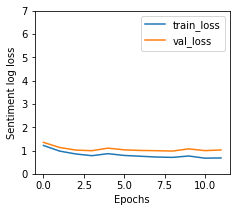

CPU times: user 39.6 s, sys: 885 ms, total: 40.5 s
Wall time: 40.4 s


In [13]:
%%time 
#torch.manual_seed(0) # SET SEED FOR TESTING
W = torch.eye(nhidden,    nhidden,   dtype=torch.float64, requires_grad=True)
U = torch.randn(nhidden,  nfeatures, dtype=torch.float64, requires_grad=True) # embed one-hot char vec
V = torch.randn(nclasses, nhidden,   dtype=torch.float64, requires_grad=True) # take RNN output (h) and predict target

optimizer = torch.optim.Adam([W,U,V], lr=0.005, weight_decay=0.0)

history = []
epochs = 12
for epoch in range(1, epochs+1):
#     print(f"EPOCH {epoch}")
    epoch_training_loss = 0.0
    epoch_training_accur = 0.0
    total = 0
    for p in range(0, n, batch_size):  # do one epoch
        loss = 0
        batch_X = X_train[p:p+batch_size]
        batch_y = y_train[p:p+batch_size]
        batch_X_onehot = onehot_matrix(batch_X, max_len, vocab)
        H = torch.zeros(nhidden, batch_size, dtype=torch.float64, requires_grad=False)
        for t in range(max_len):
            x_step_t = batch_X_onehot[:,t].T # make it len(vocab) x batch_size
            H = W.mm(H) + U.mm(x_step_t)
            H = torch.tanh(H)
        o = V.mm(H)
        o = o.T # make it batch_size x nclasses
        o = softmax(o)
        loss = cross_entropy(o, batch_y)
#         print(loss.item())
        correct = torch.argmax(o, dim=1)==batch_y
        epoch_training_accur += torch.sum(correct)
        total += len(batch_y)

        # update matrices based upon loss computed from a batch
        optimizer.zero_grad()
        loss.backward() # autograd computes U.grad, M.grad, ...
        optimizer.step()

        epoch_training_loss += loss.detach().item()

    epoch_training_loss /= nbatches
    epoch_training_accur /= n
#     print(f"Epoch {epoch:3d} training loss {epoch_training_loss:7.4f} accur {epoch_training_accur:7.4f}")

    with torch.no_grad():
        o = forward(X_train, max_len, vocab)#, apply_softmax=False)
        train_loss = cross_entropy(o, y_train).item()
        correct = torch.argmax(o, dim=1).detach()==torch.tensor(y_train)
        train_accur = torch.sum(correct) / float(len(X_train))

        o = forward(X_valid, max_len, vocab)
        valid_loss = cross_entropy(o, y_valid).item()
        correct = torch.argmax(o, dim=1).detach()==torch.tensor(y_valid)
        valid_accur = torch.sum(correct) / float(len(X_valid))

        history.append((train_loss, valid_loss))
        print(f"Epoch: {epoch:3d} accum loss {epoch_training_loss:7.4f} accur {epoch_training_accur:4.3f} | train loss {train_loss:7.4f} accur {train_accur:4.3f} | valid loss {valid_loss:7.4f} accur {valid_accur:4.3f}")

history = torch.tensor(history)
plot_history(history, yrange=(0,7))

Timing on 80% training from full data set:

```
CPU times: user 40.3 s, sys: 749 ms, total: 41 s
Wall time: 41 s
```